In [1]:
pip install -r https://raw.githubusercontent.com/rizki96/ds_challenge/master/requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import io
import bz2
import pandas as pd
import numpy as np
import geohash
import time
import datetime
import pprint
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import requests
from math import ceil
from math import sin, cos, sqrt, atan2, radians
from sklearn import preprocessing
from sklearn.cluster import DBSCAN
from shapely.geometry import MultiPoint
from geopy.distance import great_circle
from pandas.plotting import register_matplotlib_converters
from collections import OrderedDict
from itertools import islice
from keras.models import load_model

register_matplotlib_converters()

Using TensorFlow backend.


In [3]:
# from local data file
trf_df = pd.read_csv('training.csv.bz2', compression='bz2', header=0, sep=',', quotechar='"')
trf_df_sort = trf_df.sort_values(by=['day', 'timestamp'])

# from remote data file
#url="https://github.com/rizki96/ds_challenge/blob/master/Traffic%20Management/training.csv.bz2?raw=true"
#s=requests.get(url).content
#data = bz2.decompress(s)
#trf_df = pd.read_csv(io.BytesIO(data), header=0, sep=',', quotechar='"')
#trf_df_sort = trf_df.sort_values(by=['day', 'timestamp'])

In [4]:
trf_df_sort[:5]

,geohash6,day,timestamp,demand
2289,qp09sx,1,0:0,0.021212
3149,qp0dhg,1,0:0,0.013217
11052,qp03x5,1,0:0,0.157956
23011,qp09bw,1,0:0,0.001262
26180,qp03wn,1,0:0,0.032721


In [5]:
trf_df_sort["dts_cal"] = [datetime.datetime.strptime('2019-03-31 00:00:00.00', '%Y-%m-%d %H:%M:%S.%f') + datetime.timedelta(days=day, hours=int(timestamp.split(":")[0]), minutes=int(timestamp.split(":")[1])) for day,timestamp in trf_df_sort[["day", "timestamp"]].values]

In [6]:
trf_df_sort[:5]

,geohash6,day,timestamp,demand,dts_cal
2289,qp09sx,1,0:0,0.021212,2019-04-01
3149,qp0dhg,1,0:0,0.013217,2019-04-01
11052,qp03x5,1,0:0,0.157956,2019-04-01
23011,qp09bw,1,0:0,0.001262,2019-04-01
26180,qp03wn,1,0:0,0.032721,2019-04-01


# convert geohash into latitude longitude

In [7]:
trf_df_sort.loc[:, 'latlon'] = trf_df_sort.geohash6.map(lambda x: geohash.decode(x))
trf_df_sort['lat'] = [ll[0][0] for ll in trf_df_sort[['latlon']].values]
trf_df_sort['lon'] = [ll[0][1] for ll in trf_df_sort[['latlon']].values]

In [8]:
trf_df_sort[:5]

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon
2289,qp09sx,1,0:0,0.021212,2019-04-01,"(-5.32012939453125, 90.9063720703125)",-5.320129,90.906372
3149,qp0dhg,1,0:0,0.013217,2019-04-01,"(-5.25421142578125, 90.9173583984375)",-5.254211,90.917358
11052,qp03x5,1,0:0,0.157956,2019-04-01,"(-5.34210205078125, 90.6646728515625)",-5.342102,90.664673
23011,qp09bw,1,0:0,0.001262,2019-04-01,"(-5.28167724609375, 90.7305908203125)",-5.281677,90.730591
26180,qp03wn,1,0:0,0.032721,2019-04-01,"(-5.32562255859375, 90.6207275390625)",-5.325623,90.620728


# week 1 and week 2 data

In [9]:
initial_day = 1
num_of_days = 14
range_btwn_pts = 1 # in km
min_samples = 1
trf_week1 = pd.DataFrame(trf_df_sort[(trf_df_sort.day >= initial_day) & (trf_df_sort.day < (initial_day + num_of_days))])

In [10]:
trf_week1[:5]

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon
2289,qp09sx,1,0:0,0.021212,2019-04-01,"(-5.32012939453125, 90.9063720703125)",-5.320129,90.906372
3149,qp0dhg,1,0:0,0.013217,2019-04-01,"(-5.25421142578125, 90.9173583984375)",-5.254211,90.917358
11052,qp03x5,1,0:0,0.157956,2019-04-01,"(-5.34210205078125, 90.6646728515625)",-5.342102,90.664673
23011,qp09bw,1,0:0,0.001262,2019-04-01,"(-5.28167724609375, 90.7305908203125)",-5.281677,90.730591
26180,qp03wn,1,0:0,0.032721,2019-04-01,"(-5.32562255859375, 90.6207275390625)",-5.325623,90.620728


# day 1 to day 10 cluster

In [11]:
day_ids = list(range(1,11))
trf_day1 = pd.DataFrame(trf_week1[trf_week1.day.isin(day_ids)])
coords = trf_day1[['lat', 'lon']].values

In [12]:
start_time = time.time()
kms_per_radian = 6371.0088
epsilon = range_btwn_pts / kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=min_samples, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
# mark as -1 for outliers
clusters = pd.Series([coords[cluster_labels == n] for n in range(-1, num_clusters) if coords[cluster_labels == n].any()])
#clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters) if coords[cluster_labels == n].any()])
#num_clusters = len(clusters)
elapsed_time = time.time() - start_time
print('Time taken to cluster: {} secs'.format(elapsed_time))
print('Number of day {} to day {} clusters: {}'.format(day_ids[0], day_ids[-1], num_clusters))
clusters

Time taken to cluster: 266.5221230983734 secs
Number of day 1 to day 10 clusters: 83


0     [[-5.32012939453125, 90.9063720703125], [-5.35...
1     [[-5.25421142578125, 90.9173583984375], [-5.32...
2     [[-5.34210205078125, 90.6646728515625], [-5.29...
3     [[-5.28167724609375, 90.7305908203125], [-5.28...
4     [[-5.32562255859375, 90.6207275390625], [-5.35...
5     [[-5.40252685546875, 90.8184814453125], [-5.28...
6     [[-5.40252685546875, 90.6427001953125], [-5.35...
7     [[-5.29266357421875, 90.8624267578125], [-5.38...
8     [[-5.33111572265625, 90.6866455078125], [-5.39...
9     [[-5.29266357421875, 90.8514404296875], [-5.27...
10    [[-5.31463623046875, 90.6536865234375], [-5.27...
11    [[-5.32562255859375, 90.6976318359375], [-5.38...
12    [[-5.35308837890625, 90.7745361328125], [-5.36...
13    [[-5.39154052734375, 90.7086181640625], [-5.28...
14    [[-5.28717041015625, 90.8953857421875], [-5.34...
15    [[-5.32562255859375, 90.5987548828125], [-5.35...
16    [[-5.32012939453125, 90.7855224609375], [-5.32...
17    [[-5.34759521484375, 90.5877685546875], [-

# cluster centermost_points

In [13]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)
centermost_points = clusters.map(get_centermost_point)
centermost_points

0     (-5.32562255859375, 90.9063720703125)
1     (-5.33111572265625, 90.9173583984375)
2     (-5.33111572265625, 90.6646728515625)
3     (-5.28167724609375, 90.7305908203125)
4     (-5.35858154296875, 90.6207275390625)
5     (-5.33660888671875, 90.8184814453125)
6     (-5.33660888671875, 90.6427001953125)
7     (-5.35308837890625, 90.8624267578125)
8     (-5.35858154296875, 90.6866455078125)
9     (-5.35308837890625, 90.8514404296875)
10    (-5.33660888671875, 90.6536865234375)
11    (-5.34759521484375, 90.6976318359375)
12    (-5.34210205078125, 90.7745361328125)
13    (-5.34759521484375, 90.7086181640625)
14    (-5.30914306640625, 90.8953857421875)
15    (-5.36956787109375, 90.5987548828125)
16    (-5.34759521484375, 90.7855224609375)
17    (-5.37506103515625, 90.5877685546875)
18    (-5.36407470703125, 90.6097412109375)
19    (-5.35308837890625, 90.6756591796875)
20    (-5.35858154296875, 90.8734130859375)
21    (-5.26519775390625, 90.9283447265625)
22    (-5.29815673828125, 90.884

In [14]:
lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})

In [15]:
rs = rep_points.apply(lambda row: trf_day1[(trf_day1['lat']==row['lat']) & (trf_day1['lon']==row['lon'])].iloc[0], axis=1)
rs[-5:]

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon
78,qp09n4,1,9:30,0.001705,2019-04-01 09:30:00,"(-5.43548583984375, 90.9722900390625)",-5.435486,90.972290
79,qp09tv,4,10:15,0.013749,2019-04-04 10:15:00,"(-5.33111572265625, 90.9613037109375)",-5.331116,90.961304
80,qp08g4,3,23:45,0.000024,2019-04-03 23:45:00,"(-5.47943115234375, 90.8404541015625)",-5.479431,90.840454
81,qp03yh,7,0:0,0.002214,2019-04-07 00:00:00,"(-5.29266357421875, 90.6207275390625)",-5.292664,90.620728
82,qp09m7,8,3:15,0.000187,2019-04-08 03:15:00,"(-5.38604736328125, 90.9393310546875)",-5.386047,90.939331


# cluster member and centermost_point visualization

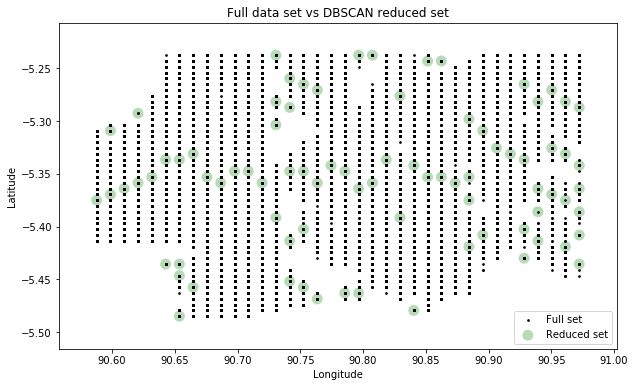

In [16]:
fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rs['lon'], rs['lat'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
df_scatter = ax.scatter(trf_day1['lon'], trf_day1['lat'], c='k', alpha=0.9, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='lower right')
plt.show()

# set label and is_centroid to cluster

In [17]:
# cluster_labels
trf_day1['cluster_ids'] = cluster_labels

In [18]:
trf_day1[:5]

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon,cluster_ids
2289,qp09sx,1,0:0,0.021212,2019-04-01,"(-5.32012939453125, 90.9063720703125)",-5.320129,90.906372,0
3149,qp0dhg,1,0:0,0.013217,2019-04-01,"(-5.25421142578125, 90.9173583984375)",-5.254211,90.917358,1
11052,qp03x5,1,0:0,0.157956,2019-04-01,"(-5.34210205078125, 90.6646728515625)",-5.342102,90.664673,2
23011,qp09bw,1,0:0,0.001262,2019-04-01,"(-5.28167724609375, 90.7305908203125)",-5.281677,90.730591,3
26180,qp03wn,1,0:0,0.032721,2019-04-01,"(-5.32562255859375, 90.6207275390625)",-5.325623,90.620728,4


In [19]:
trf_day1 = trf_day1.sort_values(by=['cluster_ids', 'dts_cal', 'demand'])
trf_day1['is_centroid'] = [(rs['geohash6'][y] == x) for x,y in trf_day1[['geohash6', 'cluster_ids']].values]

In [20]:
trf_day1[-5:]

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon,cluster_ids,is_centroid
677386,qp08g4,6,23:45,0.008822,2019-04-06 23:45:00,"(-5.47943115234375, 90.8404541015625)",-5.479431,90.840454,80,True
1325603,qp08g4,8,12:30,0.001045,2019-04-08 12:30:00,"(-5.47943115234375, 90.8404541015625)",-5.479431,90.840454,80,True
2503671,qp03yh,7,0:0,0.002214,2019-04-07 00:00:00,"(-5.29266357421875, 90.6207275390625)",-5.292664,90.620728,81,True
329088,qp03yh,8,3:30,0.003284,2019-04-08 03:30:00,"(-5.29266357421875, 90.6207275390625)",-5.292664,90.620728,81,True
1291670,qp09m7,8,3:15,0.000187,2019-04-08 03:15:00,"(-5.38604736328125, 90.9393310546875)",-5.386047,90.939331,82,True


# set highest_demand and average demand to cluster

In [21]:
trf_day1_avg_demand = trf_day1.groupby(['cluster_ids','geohash6'])['demand'].apply(lambda x: np.mean(x)).sort_values(ascending=False)
trf_day1['highest_demand'] = [trf_day1_avg_demand[x].index[0] == y for x,y in trf_day1[['cluster_ids', 'geohash6']].values]
trf_day1['avg_demand'] = [trf_day1_avg_demand[x][y] for x,y in trf_day1[['cluster_ids', 'geohash6']].values]

In [22]:
#trf_day1[(trf_day1.highest_demand == True) & (trf_day1.geohash6 == 'qp09jt')][:5]
trf_day1[(trf_day1.highest_demand == True)][-5:]

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon,cluster_ids,is_centroid,highest_demand,avg_demand
677386,qp08g4,6,23:45,0.008822,2019-04-06 23:45:00,"(-5.47943115234375, 90.8404541015625)",-5.479431,90.840454,80,True,True,0.003786
1325603,qp08g4,8,12:30,0.001045,2019-04-08 12:30:00,"(-5.47943115234375, 90.8404541015625)",-5.479431,90.840454,80,True,True,0.003786
2503671,qp03yh,7,0:0,0.002214,2019-04-07 00:00:00,"(-5.29266357421875, 90.6207275390625)",-5.292664,90.620728,81,True,True,0.002749
329088,qp03yh,8,3:30,0.003284,2019-04-08 03:30:00,"(-5.29266357421875, 90.6207275390625)",-5.292664,90.620728,81,True,True,0.002749
1291670,qp09m7,8,3:15,0.000187,2019-04-08 03:15:00,"(-5.38604736328125, 90.9393310546875)",-5.386047,90.939331,82,True,True,0.000187


# visualize time, center point and highest demand

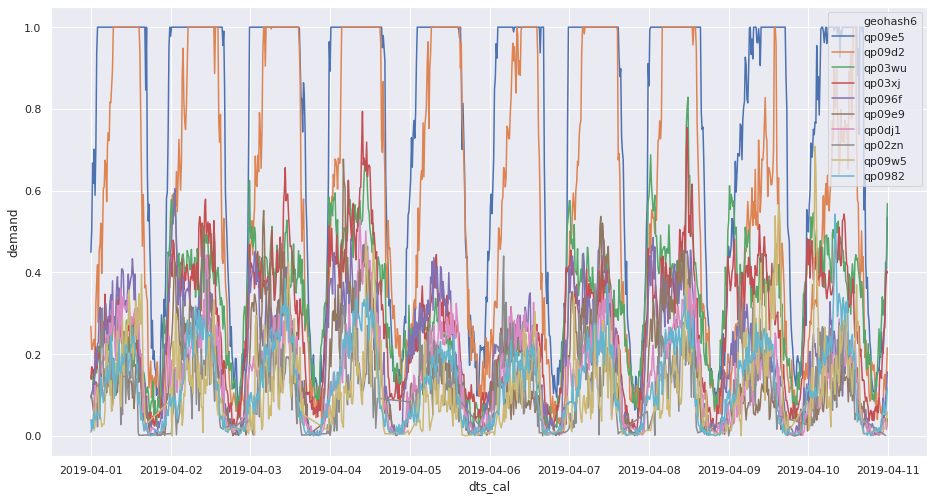

In [23]:
# observation 10 samples cluster's center point demand
trf_day1_center = pd.DataFrame(trf_day1[(trf_day1.is_centroid == True)].sort_values(by=['avg_demand', 'cluster_ids'], ascending=False))
top_clusters = list(OrderedDict.fromkeys([c[0] for c in trf_day1_center[['cluster_ids']].values]))[0:10]
top_trf_day1_center = trf_day1_center[(trf_day1_center.cluster_ids.isin(top_clusters))]
#trf_day1_cl0_others = pd.DataFrame(trf_day1[(trf_day1.is_centroid == False) & (trf_day1.cluster_ids == 0) & (trf_day1.demand > 0.0)])
#ax = sns.lineplot(x="dts_cal", y="demand", hue="geohash6", data=trf_day1_cl0_others, legend="full")
#for l in ax.lines:
#    l.set_linestyle("--")
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.lineplot(x="dts_cal", y="demand", hue="geohash6", data=top_trf_day1_center, legend="full")
plt.show()

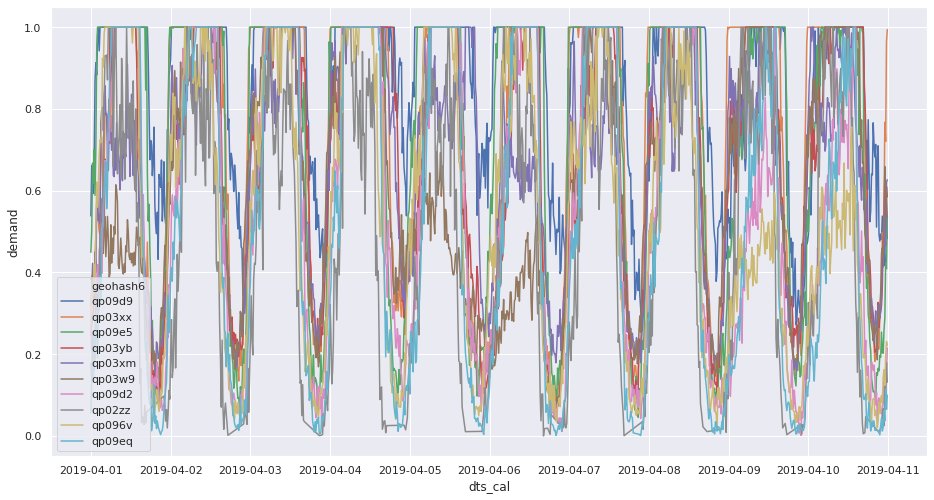

In [24]:
# observation 10 samples cluster's highest demand
trf_day1_highest = pd.DataFrame(trf_day1[(trf_day1.highest_demand == True)].sort_values(by=['avg_demand', 'cluster_ids'], ascending=False))
top_clusters = list(OrderedDict.fromkeys([c[0] for c in trf_day1_highest[['cluster_ids']].values]))[0:10]
top_trf_day1_highest = trf_day1_highest[(trf_day1_highest.cluster_ids.isin(top_clusters))]
#trf_week1_cl0_lower = pd.DataFrame(trf_week1[(trf_week1.highest_demand == False) & (trf_week1.cluster_ids == 0) & (trf_week1.demand > 0.0)])
#ax = sns.lineplot(x="dts_cal", y="demand", hue="geohash6", data=trf_week1_cl0_lower, legend="full")
#for l in ax.lines:
#    l.set_linestyle("--")
#    plt.setp(l,linewidth=1)
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.lineplot(x="dts_cal", y="demand", hue="geohash6", data=top_trf_day1_highest, legend="full")
plt.show()

# zero filling timeseries gap for cluster's highest demand

In [25]:
# looking for anomaly, is there any duplicate timeseries data (make sure it's unique)
unique = True
for c in list(OrderedDict.fromkeys([c[0] for c in trf_day1_highest[['cluster_ids']].values])):
    if not pd.Series(y for x,y in trf_day1_highest[['cluster_ids', 'dts_cal']].values if x == c).is_unique:
        print('timeseries cluster %s is not unique' % (c,))
        unique = False
if unique:
    print('all timeseries clusters are unique')

all timeseries clusters are unique


In [26]:
# reinitial dataframe, fill unset timestamp with zero
multiplier = len(day_ids)
trf_day1_complete = pd.DataFrame({'geohash6': [],
                                   'day': [],
                                   'timestamp': [],
                                   'demand': [],
                                   'dts_cal': [],
                                   'latlon': [],
                                   'lat': [], 'lon': [],
                                   'cluster_ids': [],
                                   'is_centroid': [],
                                   'highest_demand': [],
                                   'avg_demand': []})
interval_time = [datetime.timedelta(days=initial_day,minutes=15*t) for t in range(24*4*multiplier)]
start_date = datetime.datetime.strptime('2019-03-31 00:00:00.00', '%Y-%m-%d %H:%M:%S.%f')
gh = trf_day1_highest.groupby(['cluster_ids'])['geohash6'].apply(list)
demand = trf_day1_highest.groupby(['cluster_ids', 'dts_cal'])['demand'].apply(list)
avg_demand = trf_day1_highest.groupby(['cluster_ids'])['avg_demand'].apply(list)
highest_demand = trf_day1_highest.groupby(['cluster_ids'])['highest_demand'].apply(list)
is_centroid = trf_day1_highest.groupby(['cluster_ids'])['is_centroid'].apply(list)
cluster_list = list(OrderedDict.fromkeys([c[0] for c in trf_day1_highest[['cluster_ids']].values]))

trf_day1_complete['cluster_ids'] = [c for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['geohash6'] = [gh[c][0] for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['dts_cal'] = [(start_date + t) for t in interval_time for c in cluster_list]
trf_day1_complete['day'] = [int(t/(24*4)) + 1 for t in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['timestamp'] = ['%s:%s' % ((start_date + t).hour, (start_date + t).minute) for t in interval_time for c in cluster_list]
trf_day1_complete['avg_demand'] = [avg_demand[c][0] for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['highest_demand'] = [highest_demand[c][0] for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['is_centroid'] = [is_centroid[c][0] for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['demand'] = [demand[c][start_date + t][0] if (start_date + t) in demand[c] else 0 for t in interval_time for c in cluster_list]
trf_day1_complete['latlon'] = [geohash.decode(gh[c][0]) for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['lat'] = [geohash.decode(gh[c][0])[0] for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['lon'] = [geohash.decode(gh[c][0])[1] for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon,cluster_ids,is_centroid,highest_demand,avg_demand
0,qp09d9,1,0:0,0.538371,2019-04-01 00:00:00,"(-5.35308837890625, 90.8184814453125)",-5.353088,90.818481,5,False,True,0.866750
1,qp03xx,1,0:0,0.320478,2019-04-01 00:00:00,"(-5.32012939453125, 90.6866455078125)",-5.320129,90.686646,8,False,True,0.763058
2,qp09e5,1,0:0,0.449159,2019-04-01 00:00:00,"(-5.34210205078125, 90.8404541015625)",-5.342102,90.840454,37,True,True,0.754430
3,qp03yb,1,0:0,0.244790,2019-04-01 00:00:00,"(-5.31463623046875, 90.6536865234375)",-5.314636,90.653687,10,False,True,0.697859
4,qp03xm,1,0:0,0.261962,2019-04-01 00:00:00,"(-5.33111572265625, 90.6756591796875)",-5.331116,90.675659,19,False,True,0.667452
5,qp03w9,1,0:0,0.383662,2019-04-01 00:00:00,"(-5.35308837890625, 90.6427001953125)",-5.353088,90.642700,6,False,True,0.629659
6,qp09d2,1,0:0,0.268345,2019-04-01 00:00:00,"(-5.35858154296875, 90.8074951171875)",-5.358582,90.807495,29,True,True,0.582857
7,qp02zz,1,0:0,0.176994,2019-04-01 00:00:00,"(-5.45196533203125, 90.6976318359375)",-5.451965,90.697632,11,False,True,0.558947
8,qp096v,1,0:0,0.269423,2019-04-01 00:00:00,"(-5.37506103515625, 90.8294677734375)",-5.375061,90.829468,27,False,True,0.547194
9,qp09eq,1,0:0,0.055975,2019-04-01 00:00:00,"(-5.32562255859375, 90.8514404296875)",-5.325623,90.851440,9,False,True,0.547007


# visualize after zero fill gap

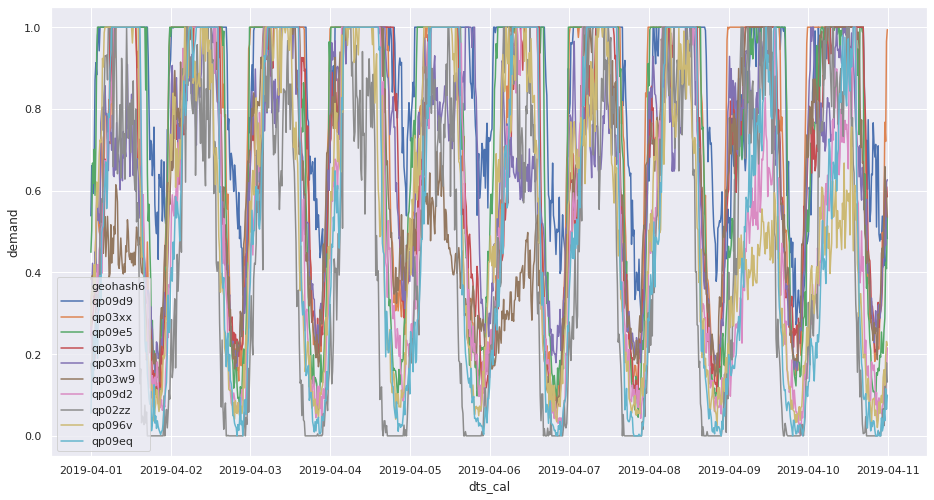

In [27]:
# observation 10 samples cluster's highest demand
top_clusters = list(OrderedDict.fromkeys([c[0] for c in trf_day1_complete[['cluster_ids']].values]))[0:10]
top_trf_day1_complete_highest = trf_day1_complete[(trf_day1_complete.cluster_ids.isin(top_clusters))]
#trf_week1_cl0_lower = pd.DataFrame(trf_week1[(trf_week1.highest_demand == False) & (trf_week1.cluster_ids == 0) & (trf_week1.demand > 0.0)])
#ax = sns.lineplot(x="dts_cal", y="demand", hue="geohash6", data=trf_week1_cl0_lower, legend="full")
#for l in ax.lines:
#    l.set_linestyle("--")
#    plt.setp(l,linewidth=1)
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.lineplot(x="dts_cal", y="demand", hue="geohash6", data=top_trf_day1_complete_highest, legend="full")
plt.show()

# timeseries prediction

In [28]:
# prepare sorted data
total_sequence_series = 24*4*multiplier # 15 minutes within 24*multiplier hours
#past_length = int(((multiplier-1) / multiplier)*total_sequence_series)
prediction_length = int(24*4*(multiplier/2))
trf_day1_complete_sort = trf_day1_complete.sort_values(by=['cluster_ids','dts_cal'], ascending=True)
print("total_sequence_series: %s, prediction_length: %s" % (total_sequence_series, prediction_length))
trf_day1_complete_sort[:5]

total_sequence_series: 960, prediction_length: 480


,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon,cluster_ids,is_centroid,highest_demand,avg_demand
21,qp09s9,1,0:0,0.075299,2019-04-01 00:00:00,"(-5.35308837890625, 90.9063720703125)",-5.353088,90.906372,0,False,True,0.214076
104,qp09s9,1,0:15,0.128943,2019-04-01 00:15:00,"(-5.35308837890625, 90.9063720703125)",-5.353088,90.906372,0,False,True,0.214076
187,qp09s9,1,0:30,0.068149,2019-04-01 00:30:00,"(-5.35308837890625, 90.9063720703125)",-5.353088,90.906372,0,False,True,0.214076
270,qp09s9,1,0:45,0.057968,2019-04-01 00:45:00,"(-5.35308837890625, 90.9063720703125)",-5.353088,90.906372,0,False,True,0.214076
353,qp09s9,1,1:0,0.097595,2019-04-01 01:00:00,"(-5.35308837890625, 90.9063720703125)",-5.353088,90.906372,0,False,True,0.214076


In [29]:
# grouping and prepare prerequisite data
start_date = datetime.datetime.strptime('2019-03-31 00:00:00.00', '%Y-%m-%d %H:%M:%S.%f')
cluster_list = list(set([c for c in trf_day1_complete_sort['cluster_ids']]))
demand = trf_day1_complete_sort.groupby(['cluster_ids', 'dts_cal'])['demand'].apply(list)

In [30]:
# second trial using keras
from lib import keras_timeseries

# setup train and test data for keras
train_day1_ds = [[demand[c][start_date + t][0] for t in interval_time[:-prediction_length]] for c in cluster_list]
test_day1_ds = [[demand[c][start_date + t][0] for t in interval_time[total_sequence_series-prediction_length:]] for c in cluster_list]

X_mat = np.matrix(';'.join([' '.join([str(d) for d in ds]) for ds in train_day1_ds]))
X_data = X_mat.round(15).reshape(len(cluster_list), total_sequence_series-prediction_length, 1)
y_mat = np.matrix(';'.join([' '.join([str(d) for d in ds]) for ds in test_day1_ds]))
y_data = y_mat.round(15).reshape(len(cluster_list), prediction_length, 1)

test_count = int(0.5*X_data.shape[0])
test_count = test_count if test_count < 32 else 32*ceil(test_count / 32)
X_train = X_data[:-(X_data.shape[0]-test_count)]
X_test = X_data[X_data.shape[0]-test_count:]

#print(X_train.shape, X_test.shape)

y_train = y_data[:-(y_data.shape[0]-test_count)]
y_test = y_data[y_data.shape[0]-test_count:]

#print(y_train.shape, y_test.shape)

N = X_train.shape[0] # size of samples
T = X_train.shape[1] # length of each time series
train_batch_size = N # number of time series considered together: batch_size | N
T_after_cut = 24 # length of each cut part of the time series: T_after_cut | T
dim_in = X_train.shape[2] # dimension of input time series
dim_out = y_train.shape[2] # dimension of output time series
test_batch_size = X_test.shape[0]

inputs, outputs = \
    [keras_timeseries.stateful_cut(arr, train_batch_size, T_after_cut) for arr in \
    [X_train, y_train]]
inputs_test, outputs_test = \
    [keras_timeseries.stateful_cut(arr, test_batch_size, T_after_cut) for arr in \
    [X_test, y_test]]
#inputs, outputs, inputs_test, outputs_testtest_count = test_count if test_count < 32 else 32*ceil(test_count / 32)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 1280 samples, validate on 1280 samples
Epoch 1/500
1280/1280 [==============================] - 1s 647us/step - loss: 0.0780 - val_loss: 0.0273
Epoch 2/500
1280/1280 [==============================] - 0s 198us/step - loss: 0.0666 - val_loss: 0.0248
Epoch 3/500
1280/1280 [==============================] - 0s 196us/step - loss: 0.0585 - val_loss: 0.0240
Epoch 4/500
1280/1280 [==============================] - 0s 205us/step - loss: 0.0523 - val_loss: 0.0239
Epoch 5/500
1280/1280 [==============================] - 0s 205us/step - loss: 0.0476 - val_loss: 0.0236
Epoch 6/500
1280/1280 [==============================] - 0s 249us/step - loss: 0.0436 - val_loss: 0.0226
Epoch 7/500
1280/1280 [==============================] - 0s 206us/step - loss: 0.0396 - val_loss: 0.0209
Epoch 8/500
1280/1280 [==============================] - 0s 196us/step - loss: 0.0356 - val_loss:

1280/1280 [==============================] - 0s 202us/step - loss: 0.0094 - val_loss: 0.0046
Epoch 73/500
1280/1280 [==============================] - 0s 200us/step - loss: 0.0094 - val_loss: 0.0046
Epoch 74/500
1280/1280 [==============================] - 0s 209us/step - loss: 0.0094 - val_loss: 0.0046
Epoch 75/500
1280/1280 [==============================] - 0s 217us/step - loss: 0.0094 - val_loss: 0.0046
Epoch 76/500
1280/1280 [==============================] - 0s 202us/step - loss: 0.0094 - val_loss: 0.0046
Epoch 77/500
1280/1280 [==============================] - 0s 208us/step - loss: 0.0094 - val_loss: 0.0046
Epoch 78/500
1280/1280 [==============================] - 0s 202us/step - loss: 0.0094 - val_loss: 0.0046
Epoch 79/500
1280/1280 [==============================] - 0s 211us/step - loss: 0.0093 - val_loss: 0.0046
Epoch 80/500
1280/1280 [==============================] - 0s 215us/step - loss: 0.0093 - val_loss: 0.0046
Epoch 81/500
1280/1280 [==============================] - 0

Epoch 149/500
1280/1280 [==============================] - 0s 198us/step - loss: 0.0092 - val_loss: 0.0046
Epoch 150/500
1280/1280 [==============================] - 0s 212us/step - loss: 0.0092 - val_loss: 0.0046
Epoch 151/500
1280/1280 [==============================] - 0s 199us/step - loss: 0.0092 - val_loss: 0.0046
Epoch 152/500
1280/1280 [==============================] - 0s 215us/step - loss: 0.0092 - val_loss: 0.0046
Epoch 153/500
1280/1280 [==============================] - 0s 204us/step - loss: 0.0092 - val_loss: 0.0046
Epoch 154/500
1280/1280 [==============================] - 0s 201us/step - loss: 0.0092 - val_loss: 0.0046
Epoch 155/500
1280/1280 [==============================] - 0s 210us/step - loss: 0.0092 - val_loss: 0.0046
Epoch 156/500
1280/1280 [==============================] - 0s 205us/step - loss: 0.0092 - val_loss: 0.0046
Epoch 157/500
1280/1280 [==============================] - 0s 230us/step - loss: 0.0092 - val_loss: 0.0046
Epoch 158/500
1280/1280 [============

1280/1280 [==============================] - 0s 190us/step - loss: 0.0092 - val_loss: 0.0046
Epoch 226/500
1280/1280 [==============================] - 0s 207us/step - loss: 0.0092 - val_loss: 0.0046
Epoch 227/500
1280/1280 [==============================] - 0s 200us/step - loss: 0.0092 - val_loss: 0.0046
Epoch 228/500
1280/1280 [==============================] - 0s 202us/step - loss: 0.0092 - val_loss: 0.0046
Epoch 229/500
1280/1280 [==============================] - 0s 197us/step - loss: 0.0092 - val_loss: 0.0046
Epoch 230/500
1280/1280 [==============================] - 0s 189us/step - loss: 0.0092 - val_loss: 0.0046
Epoch 231/500
1280/1280 [==============================] - 0s 204us/step - loss: 0.0092 - val_loss: 0.0046
Epoch 232/500
1280/1280 [==============================] - 0s 220us/step - loss: 0.0092 - val_loss: 0.0046
Epoch 233/500
1280/1280 [==============================] - 0s 230us/step - loss: 0.0092 - val_loss: 0.0046
Epoch 234/500
1280/1280 [==========================

1280/1280 [==============================] - 0s 202us/step - loss: 0.0092 - val_loss: 0.0046
Epoch 302/500
1280/1280 [==============================] - 0s 200us/step - loss: 0.0092 - val_loss: 0.0046
Epoch 303/500
1280/1280 [==============================] - 0s 207us/step - loss: 0.0092 - val_loss: 0.0046
Epoch 304/500
1280/1280 [==============================] - 0s 201us/step - loss: 0.0092 - val_loss: 0.0046
Epoch 305/500
1280/1280 [==============================] - 0s 206us/step - loss: 0.0092 - val_loss: 0.0046
Epoch 306/500
1280/1280 [==============================] - 0s 199us/step - loss: 0.0092 - val_loss: 0.0046
Epoch 307/500
1280/1280 [==============================] - 0s 211us/step - loss: 0.0092 - val_loss: 0.0046
Epoch 308/500
1280/1280 [==============================] - 0s 200us/step - loss: 0.0092 - val_loss: 0.0046
Epoch 309/500
1280/1280 [==============================] - 0s 237us/step - loss: 0.0092 - val_loss: 0.0046
Epoch 310/500
1280/1280 [==========================

1280/1280 [==============================] - 0s 198us/step - loss: 0.0092 - val_loss: 0.0046
Epoch 378/500
1280/1280 [==============================] - 0s 189us/step - loss: 0.0092 - val_loss: 0.0046
Epoch 379/500
1280/1280 [==============================] - 0s 201us/step - loss: 0.0092 - val_loss: 0.0046
Epoch 380/500
1280/1280 [==============================] - 0s 199us/step - loss: 0.0092 - val_loss: 0.0046
Epoch 381/500
1280/1280 [==============================] - 0s 198us/step - loss: 0.0092 - val_loss: 0.0046
Epoch 382/500
1280/1280 [==============================] - 0s 195us/step - loss: 0.0092 - val_loss: 0.0046
Epoch 383/500
1280/1280 [==============================] - 0s 202us/step - loss: 0.0092 - val_loss: 0.0046
Epoch 384/500
1280/1280 [==============================] - 0s 193us/step - loss: 0.0092 - val_loss: 0.0046
Epoch 385/500
1280/1280 [==============================] - 0s 231us/step - loss: 0.0092 - val_loss: 0.0046
Epoch 386/500
1280/1280 [==========================

1280/1280 [==============================] - 0s 207us/step - loss: 0.0092 - val_loss: 0.0046
Epoch 454/500
1280/1280 [==============================] - 0s 204us/step - loss: 0.0092 - val_loss: 0.0046
Epoch 455/500
1280/1280 [==============================] - 0s 217us/step - loss: 0.0092 - val_loss: 0.0046
Epoch 456/500
1280/1280 [==============================] - 0s 202us/step - loss: 0.0092 - val_loss: 0.0046
Epoch 457/500
1280/1280 [==============================] - 0s 202us/step - loss: 0.0092 - val_loss: 0.0046
Epoch 458/500
1280/1280 [==============================] - 0s 204us/step - loss: 0.0092 - val_loss: 0.0046
Epoch 459/500
1280/1280 [==============================] - 0s 200us/step - loss: 0.0092 - val_loss: 0.0046
Epoch 460/500
1280/1280 [==============================] - 0s 202us/step - loss: 0.0092 - val_loss: 0.0046
Epoch 461/500
1280/1280 [==============================] - 0s 196us/step - loss: 0.0092 - val_loss: 0.0046
Epoch 462/500
1280/1280 [==========================

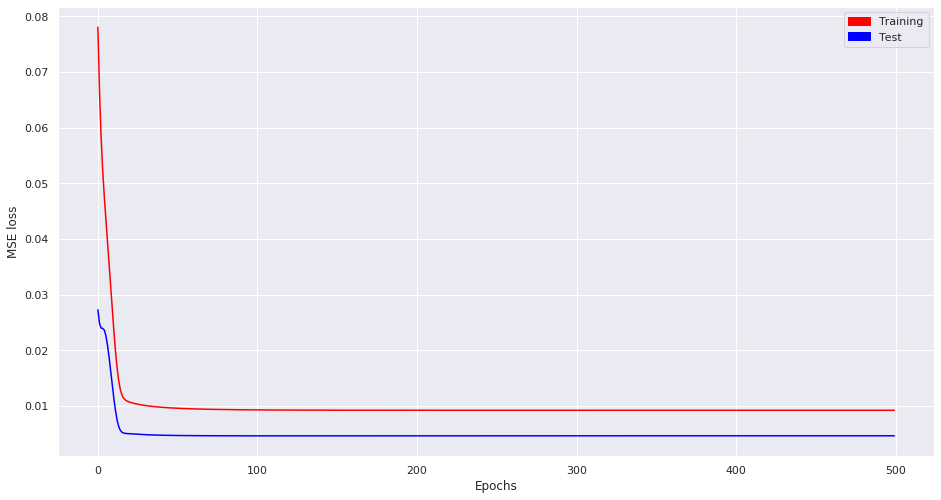

In [31]:
# building network and training
model = keras_timeseries.build_model(train_batch_size, int(total_sequence_series/T), dim_in, dim_out, T_after_cut)
epochs = 500
history = keras_timeseries.train_model(model, inputs, outputs, inputs_test, outputs_test,
                N, T, epochs, train_batch_size, test_batch_size, T_after_cut)
keras_timeseries.plotting(history)

# saving the model
model_path = 'model/keras-epoch%s-stateful-%sdays.lstm' % (epochs, len(day_ids))
model.save(model_path)

In [32]:
# predicting and evaluating
model = load_model(model_path)
# After 500 epochs: loss: 0.0092 / val_loss: 0.0047.

interval=64
first_idx = range(0, interval)
second_idx = range(len(cluster_list)-interval, len(cluster_list))

first_x = X_data[first_idx]
first_y = y_data[first_idx]
first_yhat = model.predict(first_x, batch_size=interval)

second_x = X_data[second_idx]
second_y = y_data[second_idx]
second_yhat = model.predict(second_x, batch_size=interval)

actual_x = [first_x[c] for c in first_idx]
actual_x.extend([second_x[c] for c in range(interval-(len(cluster_list)-interval), interval)])
actual_y = [first_y[c] for c in first_idx]
actual_y.extend([second_y[c] for c in range(interval-(len(cluster_list)-interval), interval)])
predicted_y = [first_yhat[c] for c in first_idx]
predicted_y.extend([second_yhat[c] for c in range(interval-(len(cluster_list)-interval), interval)])

result_df = pd.DataFrame({
    'actual_demand': [],
    'predicted_demand': [],
    'cluster_ids': [],
    'ts': []})

actual_x_df = pd.DataFrame([actual_x[c][t][0] for t in range(24*2*multiplier) for c in cluster_list])
actual_y_df = pd.DataFrame([actual_y[c][t][0] for t in range(24*2*multiplier) for c in cluster_list])
predicted_x_df = pd.DataFrame([float('nan') for _ in range(24*2*multiplier) for _ in cluster_list])
predicted_y_df = pd.DataFrame([predicted_y[c][t][0] for t in range(24*2*multiplier) for c in cluster_list])

result_df['cluster_ids'] = [c for _ in interval_time for c in cluster_list]
result_df['ts'] = [start_date + t for t in interval_time for _ in cluster_list]
actual_result = actual_x_df.append(actual_y_df)
predicted_result = predicted_x_df.append(predicted_y_df)
result_df = result_df.sort_values(['ts', 'cluster_ids'])
result_df['actual_demand'] = [res for res in actual_result[0]]
result_df['predicted_demand'] = [res for res in predicted_result[0]]

#result_df[result_df.cluster_ids == 0]
top_result_df = result_df[result_df.cluster_ids.isin(top_clusters)]

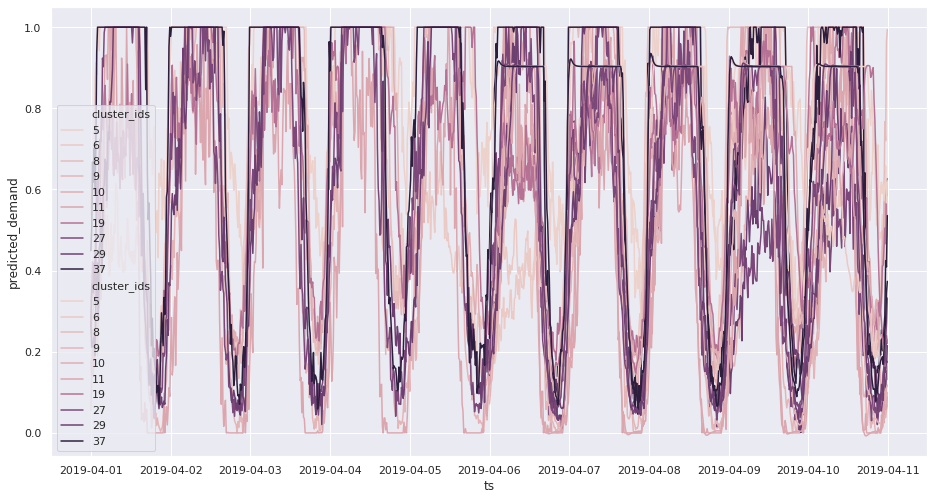

In [33]:
fig, ax = plt.subplots()
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(15.7,8.27)})
ax = sns.lineplot(x="ts", y="actual_demand", hue="cluster_ids", ax=ax, data=top_result_df, legend="full")
ax = sns.lineplot(x="ts", y="predicted_demand", hue="cluster_ids", ax=ax, data=top_result_df, legend="full")

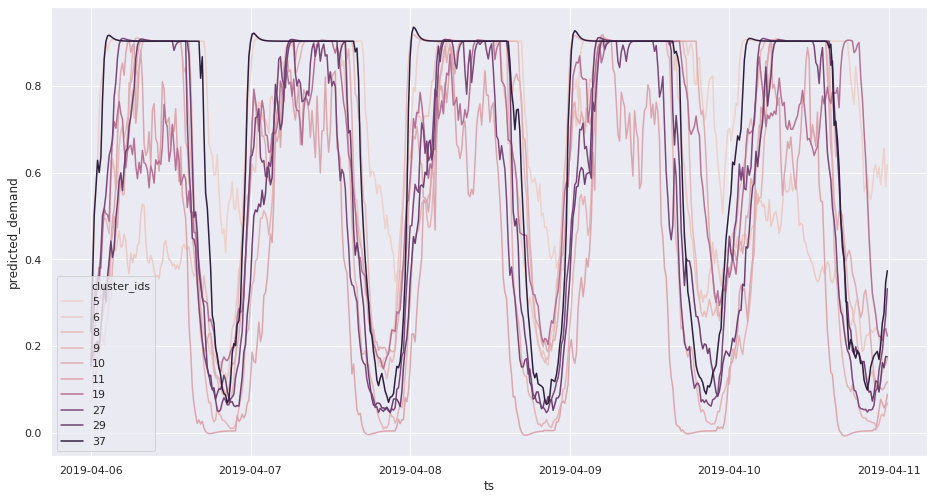

In [34]:
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.lineplot(x="ts", y="predicted_demand", hue="cluster_ids", data=top_result_df, legend="full")
plt.show()

# find predicted demand of a geohash point by datetime

In [35]:
def measure_distance(x1, y1, x2, y2):
    R = 6373.0

    lat1 = radians(x1)
    lon1 = radians(y1)
    lat2 = radians(x2)
    lon2 = radians(y2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return R * c

In [36]:
trf_day1[(trf_day1.is_centroid == False) & (trf_day1.highest_demand == False)].sort_values(['dts_cal'])

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon,cluster_ids,is_centroid,highest_demand,avg_demand
1071697,qp09kw,1,0:0,0.000240,2019-04-01 00:00:00,"(-5.36956787109375, 90.9063720703125)",-5.369568,90.906372,0,False,False,0.070737
3037869,qp03q3,1,0:0,0.062436,2019-04-01 00:00:00,"(-5.39703369140625, 90.6317138671875)",-5.397034,90.631714,25,False,False,0.060414
1080329,qp03q2,1,0:0,0.048801,2019-04-01 00:00:00,"(-5.40252685546875, 90.6317138671875)",-5.402527,90.631714,25,False,False,0.103826
965945,qp03wr,1,0:0,0.032079,2019-04-01 00:00:00,"(-5.32012939453125, 90.6317138671875)",-5.320129,90.631714,25,False,False,0.056681
449731,qp03q6,1,0:0,0.030174,2019-04-01 00:00:00,"(-5.39154052734375, 90.6317138671875)",-5.391541,90.631714,25,False,False,0.049419
1068980,qp03wm,1,0:0,0.029962,2019-04-01 00:00:00,"(-5.33111572265625, 90.6317138671875)",-5.331116,90.631714,25,False,False,0.070123
1775640,qp03wq,1,0:0,0.028225,2019-04-01 00:00:00,"(-5.32562255859375, 90.6317138671875)",-5.325623,90.631714,25,False,False,0.043380
3091571,qp03y7,1,0:0,0.021446,2019-04-01 00:00:00,"(-5.29815673828125, 90.6317138671875)",-5.298157,90.631714,25,False,False,0.050246
2419540,qp03w6,1,0:0,0.021174,2019-04-01 00:00:00,"(-5.34759521484375, 90.6317138671875)",-5.347595,90.631714,25,False,False,0.055247
2527149,qp03nr,1,0:0,0.018635,2019-04-01 00:00:00,"(-5.40802001953125, 90.6317138671875)",-5.408020,90.631714,25,False,False,0.101286


In [37]:
# prepare data day n+(n/2) for evaluation
initial_week3 = day_ids[-1] + 1
num_of_days = int(len(day_ids) / 2)
trf_week3 = pd.DataFrame(trf_df_sort[(trf_df_sort.day >= initial_week3) & (trf_df_sort.day < (initial_week3 + num_of_days))])
trf_week3 = trf_week3.sort_values(['geohash6', 'dts_cal'])
geohash_list = list(set([c for c in trf_week3['geohash6']]))

trf_week3_complete = pd.DataFrame({'geohash6': [],
                                   'day': [],
                                   'timestamp': [],
                                   'demand': [],
                                   'dts_cal': []})
interval_time = [datetime.timedelta(days=initial_week3,minutes=15*t) for t in range(24*4*num_of_days)]
gh = trf_week3.groupby(['geohash6', 'dts_cal'])['geohash6'].apply(list)
demand = trf_week3.groupby(['geohash6', 'dts_cal'])['demand'].apply(list)

trf_week3_complete['geohash6'] = [gh[c][0][0] for _ in range(24*4*num_of_days) for c in geohash_list]
trf_week3_complete['dts_cal'] = [(start_date + t) for t in interval_time for c in geohash_list]
trf_week3_complete['day'] = [int(t/(24*4)) + 1 for t in range(24*4*num_of_days) for c in geohash_list]
trf_week3_complete['timestamp'] = ['%s:%s' % ((start_date + t).hour, (start_date + t).minute) for t in interval_time for c in geohash_list]
trf_week3_complete['demand'] = [demand[c][start_date + t][0] if (start_date + t) in demand[c] else 0 for t in interval_time for c in geohash_list]
trf_week3_complete

,geohash6,day,timestamp,demand,dts_cal
0,qp09jr,1,0:0,0.000000,2019-04-11 00:00:00
1,qp03ye,1,0:0,0.142327,2019-04-11 00:00:00
2,qp0dj5,1,0:0,0.032649,2019-04-11 00:00:00
3,qp03mz,1,0:0,0.056972,2019-04-11 00:00:00
4,qp09dr,1,0:0,0.032784,2019-04-11 00:00:00
5,qp099e,1,0:0,0.070995,2019-04-11 00:00:00
6,qp03ws,1,0:0,0.205518,2019-04-11 00:00:00
7,qp09mz,1,0:0,0.000000,2019-04-11 00:00:00
8,qp08gk,1,0:0,0.000000,2019-04-11 00:00:00
9,qp0dj0,1,0:0,0.049261,2019-04-11 00:00:00


In [38]:
# find input point's distance from centermost
input_point = 'qp09ux' # 1 cluster sample
input_point = 'qp096h'
input_point = 'qp09hm'
latlon = geohash.decode(input_point)
#latlon
trf_day1_dist = pd.DataFrame(trf_day1)
trf_day1_dist['distance'] = trf_day1_dist.latlon.apply(lambda latlon2: measure_distance(latlon[0], latlon[1], latlon2[0], latlon2[1]))
trf_day1_dist = trf_day1_dist.sort_values(['distance', 'dts_cal'])
search_cluster = trf_day1_dist['cluster_ids'].iloc[0]
data_sample = trf_day1_complete[(trf_day1_complete.cluster_ids == search_cluster) & (trf_day1_complete.highest_demand == True)]
sample_geohash = data_sample['geohash6'].iloc[0]
trf_week3_eval = trf_week3[(trf_week3.geohash6 == sample_geohash)]

interval=64
first_idx = range(0, interval)
interval_time = [datetime.timedelta(days=initial_day,minutes=15*t) for t in range(24*4*multiplier)]

X_actual_data = [[[[data_sample['demand'].iloc[idx]] for idx,_ in enumerate(interval_time[:-prediction_length])] for _ in first_idx]]
y_actual_data = [[[[data_sample['demand'].iloc[idx]] for idx,_ in enumerate(interval_time[total_sequence_series-prediction_length:])] for _ in first_idx]]
predicted_actual_data = model.predict(X_actual_data, batch_size=interval)

eval_sample = trf_week3_complete[trf_week3_complete.geohash6 == sample_geohash]
X_eval_data = predicted_actual_data
y_eval_data = [[[[eval_sample['demand'].iloc[idx]] for idx,_ in enumerate(interval_time[:-prediction_length])] for _ in first_idx]]
predicted_eval_data = model.predict(X_eval_data, batch_size=interval)


# actual vs predicted per cluster highest demand

In [39]:
X_actual_df = pd.DataFrame([X_actual_data[0][c][t][0] for t in range(24*2*multiplier) for c in first_idx[:1]])
y_actual_df = pd.DataFrame([y_actual_data[0][c][t][0] for t in range(24*2*multiplier) for c in first_idx[:1]])
X_predicted_df = pd.DataFrame([float('nan') for _ in range(24*2*multiplier) for _ in first_idx[:1]])
y_predicted_df = pd.DataFrame([predicted_actual_data[c][t][0] for t in range(24*2*multiplier) for c in first_idx[:1]])

y_eval_df = pd.DataFrame([y_eval_data[0][c][t][0] for t in range(24*2*multiplier) for c in first_idx[:1]])
y_predicted_eval_df = pd.DataFrame([predicted_eval_data[c][t][0] for t in range(24*2*multiplier) for c in first_idx[:1]])

ext_interval_time = [datetime.timedelta(days=initial_day,minutes=15*t) for t in range(24*4*(multiplier+num_of_days))]

result_df = pd.DataFrame({
    'actual_demand': [],
    'predicted_demand': [],
    'predicted_50_quant': [],
    'predicted_90_quant': [],
    'ts': []})

result_df['ts'] = [start_date + t for t in ext_interval_time for _ in first_idx[:1]]
#result_df['ts'] = [datetime.datetime.timestamp(start_date + t) for t in ext_interval_time for _ in first_idx[:1]]
#print(len([start_date + t for t in ext_interval_time for _ in first_idx[:1]]))

#rng = pd.date_range('2019-04-01 00:00:00', periods=24*4*(multiplier+num_of_days), freq='15min')
#result_df['ts'] = rng
#result_df.set_index(['ts'])
#result_df.index = pd.to_datetime(result_df.index, unit='s')

actual_result = X_actual_df.append(y_actual_df).append(y_eval_df)
predicted_result = X_predicted_df.append(y_predicted_df).append(y_predicted_eval_df)
result_df = result_df.sort_values(['ts'])
result_df['ts'] = pd.to_datetime(result_df.ts)
result_df.index = pd.DatetimeIndex(result_df.ts)
result_df.set_index('ts')
result_df['actual_demand'] = [res for res in actual_result[0]]
result_df['predicted_demand'] = [res for res in predicted_result[0]]

g = result_df.groupby([pd.Grouper(freq='H')])
result_df['predicted_50_quant'] = g.quantile(0.50)['predicted_demand']
result_df['predicted_90_quant'] = g.quantile(0.90)['predicted_demand']

result_df
#melted_df = pd.melt(result_df, id_vars=[], 
#                   value_vars=result_df['ts'],
#                   value_name='predicted_demand',
#                   var_name=['ts'])
#melted_df

,actual_demand,predicted_demand,predicted_50_quant,predicted_90_quant,ts
ts,,,,,
2019-04-01 00:00:00,0.018698,NaN,NaN,NaN,2019-04-01 00:00:00
2019-04-01 00:15:00,0.025944,NaN,NaN,NaN,2019-04-01 00:15:00
2019-04-01 00:30:00,0.043221,NaN,NaN,NaN,2019-04-01 00:30:00
2019-04-01 00:45:00,0.041554,NaN,NaN,NaN,2019-04-01 00:45:00
2019-04-01 01:00:00,0.022946,NaN,NaN,NaN,2019-04-01 01:00:00
2019-04-01 01:15:00,0.028194,NaN,NaN,NaN,2019-04-01 01:15:00
2019-04-01 01:30:00,0.060060,NaN,NaN,NaN,2019-04-01 01:30:00
2019-04-01 01:45:00,0.046125,NaN,NaN,NaN,2019-04-01 01:45:00
2019-04-01 02:00:00,0.075024,NaN,NaN,NaN,2019-04-01 02:00:00


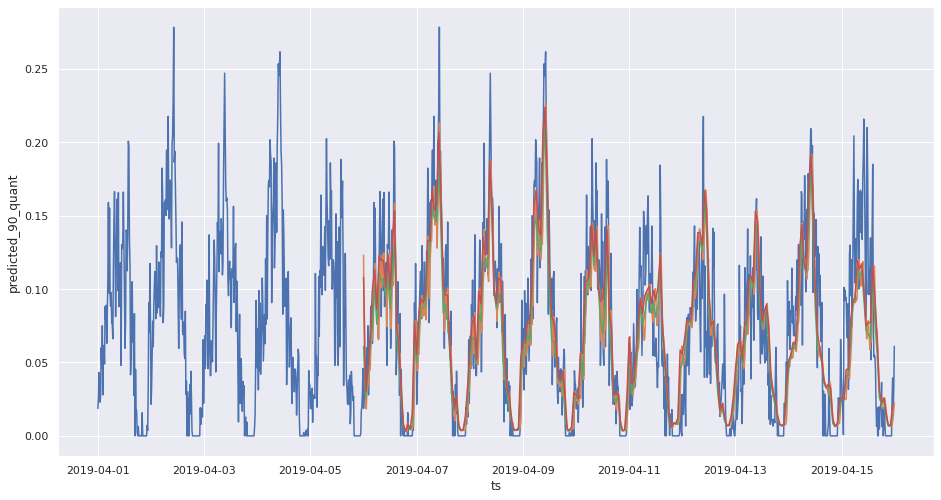

In [40]:
fig, ax = plt.subplots()
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(15.7,8.27)})
ax = sns.lineplot(x="ts", y="actual_demand", data=result_df, ax=ax)
ax = sns.lineplot(x="ts", y="predicted_demand", data=result_df, ci="sd", err_style="band", ax=ax)
ax = sns.lineplot(x="ts", y="predicted_50_quant", data=result_df, ci=50, ax=ax, legend="full")
ax = sns.lineplot(x="ts", y="predicted_90_quant", data=result_df, ci=90, ax=ax, legend="full")
#sns.tsplot([result_df.actual_demand, result_df.predicted_demand])